In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data

In [39]:
mnist = input_data.read_data_sets('./inputs/mnist')

Extracting ./inputs/mnist\train-images-idx3-ubyte.gz
Extracting ./inputs/mnist\train-labels-idx1-ubyte.gz
Extracting ./inputs/mnist\t10k-images-idx3-ubyte.gz
Extracting ./inputs/mnist\t10k-labels-idx1-ubyte.gz


# Inspecting

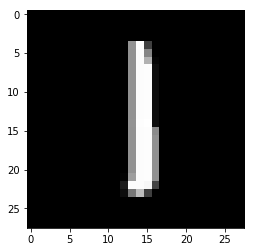

In [40]:
plt.imshow(mnist.train.images[12].reshape(28, 28), cmap='gray')

# Building a generator

- takes inputs z
- applies leaky relu activation function
- outputs result as it's a generator

In [82]:
# Resetting TF Graph
tf.reset_default_graph()
def generator(z, reuse=None):
    with tf.variable_scope('gen', reuse=reuse):
        
        alpha = 0.1
        hidden1 = tf.layers.dense(inputs=z, units=128)
        # TODO: Please use https://www.tensorflow.org/api_docs/python/tf/nn/leaky_relu
        hidden1 = tf.maximum(alpha*hidden1, hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        
        output = tf.layers.dense(hidden2, units=784, activation=tf.nn.tanh)
        
        return output

# Building a descriminator

In [83]:
def descriminator(X, reuse=None):
    with tf.variable_scope('dis', reuse=reuse):
        
        alpha = 0.1
        hidden1 = tf.layers.dense(inputs=X, units=128)
        # TODO: Please use https://www.tensorflow.org/api_docs/python/tf/nn/leaky_relu
        hidden1 = tf.maximum(alpha*hidden1, hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        
        logits = tf.layers.dense(hidden2, units=1)
        output = tf.sigmoid(logits)
        return output, logits

In [84]:
# Generator placeholders
real_images = tf.placeholder(tf.float32, shape=[None, 784])
z = tf.placeholder(tf.float32, shape=[None, 100])

In [85]:
G = generator(z)

In [86]:
D_output_real, D_logits_real = descriminator(real_images)

In [87]:
D_output_fake, D_logits_fake = descriminator(G, reuse=True)

In [88]:
# Losses helper function

def loss_func(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits_in, labels=labels_in))

In [91]:
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real) * 0.9)
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_real))

In [92]:
D_loss = D_real_loss + D_fake_loss

In [93]:
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake))

In [94]:
learning_rate = 0.001

In [95]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'gen' in var.name]
g_vars = [var for var in tvars if 'dis' in var.name]

In [98]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)

In [99]:
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

In [100]:
d_vars

[<tf.Variable 'gen/dense/kernel:0' shape=(100, 128) dtype=float32_ref>,
 <tf.Variable 'gen/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gen/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'gen/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gen/dense_2/kernel:0' shape=(128, 784) dtype=float32_ref>,
 <tf.Variable 'gen/dense_2/bias:0' shape=(784,) dtype=float32_ref>]

In [101]:
g_vars

[<tf.Variable 'dis/dense/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/bias:0' shape=(1,) dtype=float32_ref>]

In [102]:
# Hyperparams
batch_size = 100
epochs = 30
init = tf.global_variables_initializer()
samples = []

In [105]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        # Calculating how many batches does it take to go through all the examples
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images * 2 - 1
            
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
        print('ON EPOCH {}'.format(epoch))
        
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z, reuse=True), feed_dict={z: sample_z})
        
        samples.append(gen_sample)

ON EPOCH 0
ON EPOCH 1
ON EPOCH 2
ON EPOCH 3
ON EPOCH 4
ON EPOCH 5
ON EPOCH 6
ON EPOCH 7
ON EPOCH 8
ON EPOCH 9
ON EPOCH 10
ON EPOCH 11
ON EPOCH 12
ON EPOCH 13
ON EPOCH 14
ON EPOCH 15
ON EPOCH 16
ON EPOCH 17
ON EPOCH 18
ON EPOCH 19
ON EPOCH 20
ON EPOCH 21
ON EPOCH 22
ON EPOCH 23
ON EPOCH 24
ON EPOCH 25
ON EPOCH 26
ON EPOCH 27
ON EPOCH 28
ON EPOCH 29


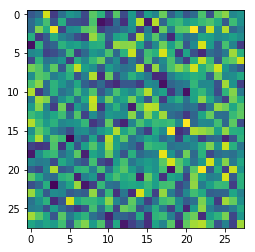

In [114]:
# Still pretty noisy
plt.imshow(samples[0].reshape(28, 28))

In [115]:
saver = tf.train.Saver(var_list=g_vars)

In [118]:
new_samples = []

with tf.Session() as sess:
    # I will post this soon
    saver.restore(sess, './models/500_epochs_model.ckpt')
    for x in range(5):
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z, reuse=True), feed_dict={z: sample_z})
        new_samples.append(gen_sample)

INFO:tensorflow:Restoring parameters from ./models/500_epochs_model.ckpt


InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on ./models/500_epochs_model.ckpt: Not found: FindFirstFile failed for: ./models : The system cannot find the path specified.

	 [[Node: save/RestoreV2_5 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_5/tensor_names, save/RestoreV2_5/shape_and_slices)]]

Caused by op 'save/RestoreV2_5', defined at:
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-115-f8279ab605aa>", line 1, in <module>
    saver = tf.train.Saver(var_list=g_vars)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\tensorflow\python\training\saver.py", line 1056, in __init__
    self.build()
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\tensorflow\python\training\saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\tensorflow\python\training\saver.py", line 691, in build
    restore_sequentially, reshape)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\tensorflow\python\training\saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\tensorflow\python\training\saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 669, in restore_v2
    dtypes=dtypes, name=name)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to get matching files on ./models/500_epochs_model.ckpt: Not found: FindFirstFile failed for: ./models : The system cannot find the path specified.

	 [[Node: save/RestoreV2_5 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_5/tensor_names, save/RestoreV2_5/shape_and_slices)]]
